# Embeddings Through Time: One-Hot → TF-IDF → Word2Vec/GloVe/FastText → BERT/Transformers

This notebook demonstrates how word representations evolved:

- **Sparse / classical**: One-Hot, TF-IDF  
- **Dense / static**: Word2Vec, GloVe, FastText  
- **Dense / contextual**: BERT token embeddings, Sentence-Transformer embeddings

We use 6 example words (plus 2 ambiguous words in two contexts) and visualize embeddings by:
1) computing embeddings
2) reducing them to 2D using PCA
3) plotting points with labels to compare semantic geometry across embedding types


## 1) Setup: install packages and import libraries

This notebook is designed for Google Colab.
We install:
- `gensim` for Word2Vec/FastText
- `transformers` for BERT
- `sentence-transformers` for modern Transformer embeddings
- `scikit-learn` for TF-IDF and PCA


In [1]:
!pip -q install gensim transformers sentence-transformers scikit-learn matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 23.8 MB/s eta 0:00:00


## 2) Define example words + contexts

Transformer embeddings are **contextual**, meaning the same word can get different vectors depending on the sentence.

We showcase this with:
- **bank** (finance vs river)
- **python** (programming vs animal)

We will plot 8 labeled points:
- bank_finance, bank_river
- python_programming, python_animal
- money, river, snake, code


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import torch
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

from gensim.models import Word2Vec, FastText

# ---- Base words ----
base_words = ["bank", "money", "river", "python", "snake", "code"]

# ---- Context sentences (8 points) ----
items = {
    "bank_finance": "I deposited cash at the bank yesterday.",
    "bank_river": "We sat on the bank of the river.",
    "python_programming": "I wrote a script in python to clean the data.",
    "python_animal": "The python wrapped around the branch.",
    "money": "She saved money for the trip.",
    "river": "The river flooded after heavy rain.",
    "snake": "A snake crossed the trail.",
    "code": "I refactored the code to improve performance."
}

labels = list(items.keys())
sentences = list(items.values())

# A small corpus for TF-IDF / Word2Vec / FastText training (toy but sufficient for demo)
corpus = sentences + [
    "Banks offer loans and financial products.",
    "The river bank was muddy after the storm.",
    "Python is popular for machine learning.",
    "The snake slithered quietly near the river.",
    "Clean code improves maintainability.",
    "Money management is important in banking."
]

print("Labels:", labels)
print("Example:", labels[0], "->", items[labels[0]])


Labels: ['bank_finance', 'bank_river', 'python_programming', 'python_animal', 'money', 'river', 'snake', 'code']
Example: bank_finance -> I deposited cash at the bank yesterday.


## 3) Tokenization helper

Word2Vec and FastText require tokenized text.
We keep tokenization simple for clarity (lowercasing + split).


In [3]:
def simple_tokenize(text: str):
    return text.lower().replace(".", "").replace(",", "").split()

tokenized_corpus = [simple_tokenize(s) for s in corpus]
tokenized_items = {k: simple_tokenize(v) for k, v in items.items()}

tokenized_corpus[:2], tokenized_items["bank_finance"]


([['i', 'deposited', 'cash', 'at', 'the', 'bank', 'yesterday'],
  ['we', 'sat', 'on', 'the', 'bank', 'of', 'the', 'river']],
 ['i', 'deposited', 'cash', 'at', 'the', 'bank', 'yesterday'])

## 4) One-Hot embeddings (classic sparse)

One-hot represents each word as a vector with:
- length = vocabulary size
- a single 1 at the word's index, otherwise 0

This has **no notion of similarity**; all words are equally far apart.
For this demo, we build a vocabulary from our 6 base words.


In [4]:
def one_hot_embeddings(words):
    vocab = {w: i for i, w in enumerate(words)}
    dim = len(vocab)
    emb = {}
    for w in words:
        v = np.zeros(dim, dtype=np.float32)
        v[vocab[w]] = 1.0
        emb[w] = v
    return emb

onehot = one_hot_embeddings(base_words)

# Map our 8 labels to vectors:
# For contextual labels (bank_finance/bank_river), we use the same word-level vector "bank"
# Same for python_programming/python_animal -> "python"
def get_base_word(label):
    if label.startswith("bank_"):
        return "bank"
    if label.startswith("python_"):
        return "python"
    return label

onehot_vectors = np.vstack([onehot[get_base_word(l)] for l in labels])
onehot_vectors.shape


(8, 6)

## 5) TF-IDF embeddings (sparse, corpus-based)

TF-IDF creates a sparse vector per *document/sentence* based on:
- term frequency in the sentence
- inverse document frequency across the corpus

Here, each of our 8 items is a sentence, so TF-IDF is naturally sentence-level.
This gives some notion of similarity via shared words, but it is not semantic.


In [5]:
tfidf = TfidfVectorizer(lowercase=True)
tfidf.fit(corpus)

tfidf_vectors = tfidf.transform(sentences).toarray().astype(np.float32)
tfidf_vectors.shape


(8, 58)

## 6) Word2Vec embeddings (dense, static)

Word2Vec learns dense vectors such that words appearing in similar contexts get similar vectors.
This model is **static**: each word has exactly one vector (no context variation).

We train a small Word2Vec model on our toy corpus (for demonstration).
In real systems, Word2Vec is trained on massive text.


In [6]:
w2v = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=50,
    window=4,
    min_count=1,
    workers=2,
    sg=1,  # skip-gram
    epochs=200
)

def w2v_label_vector(label):
    w = get_base_word(label)
    return w2v.wv[w]

w2v_vectors = np.vstack([w2v_label_vector(l) for l in labels]).astype(np.float32)
w2v_vectors.shape


(8, 50)

## 7) FastText embeddings (dense, static, subword-aware)

FastText is similar to Word2Vec but incorporates character n-grams.
This helps with:
- rare words
- spelling variants
- morphologically rich languages

We train a small FastText model on the same toy corpus.


In [7]:
ft = FastText(
    sentences=tokenized_corpus,
    vector_size=50,
    window=4,
    min_count=1,
    workers=2,
    sg=1,
    epochs=200
)

def ft_label_vector(label):
    w = get_base_word(label)
    return ft.wv[w]

ft_vectors = np.vstack([ft_label_vector(l) for l in labels]).astype(np.float32)
ft_vectors.shape


(8, 50)

## 8) GloVe embeddings (pretrained, static)

GloVe is a classic pretrained embedding trained on very large corpora.
Unlike Word2Vec/FastText training here (toy corpus), pretrained GloVe provides
stronger semantic structure out of the box.

We download a small pretrained set (`glove.6B.50d`) and extract vectors.


In [8]:
import os, zipfile, urllib.request

GLOVE_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
ZIP_PATH = "glove.6B.zip"
GLOVE_TXT = "glove.6B.50d.txt"

if not os.path.exists(GLOVE_TXT):
    if not os.path.exists(ZIP_PATH):
        print("Downloading GloVe...")
        urllib.request.urlretrieve(GLOVE_URL, ZIP_PATH)
    print("Unzipping...")
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extract(GLOVE_TXT)

print("Ready:", GLOVE_TXT)

# Load only needed words to keep it fast
needed = set([get_base_word(l) for l in labels])
glove = {}

with open(GLOVE_TXT, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split()
        w = parts[0]
        if w in needed:
            glove[w] = np.array(parts[1:], dtype=np.float32)

missing = needed - set(glove.keys())
print("Loaded:", glove.keys())
print("Missing:", missing)

glove_vectors = np.vstack([glove[get_base_word(l)] for l in labels]).astype(np.float32)
glove_vectors.shape


Unzipping...
Ready: glove.6B.50d.txt
Loaded: dict_keys(['bank', 'money', 'river', 'code', 'snake', 'python'])
Missing: set()


(8, 50)

## 9) BERT token embeddings (contextual, token-level)

BERT produces **contextual embeddings**:
- The vector for "bank" in a finance sentence differs from "bank" near "river"
- Same for "python" (programming vs animal)

We embed each sentence using BERT and extract the embedding corresponding to:
- the target word token(s) in that sentence
If the word is split into subwords, we average those subword vectors.

This section showcases why Transformers are fundamentally different from classic embeddings.


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

bert_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_name)
bert_model = AutoModel.from_pretrained(bert_name).to(device)
bert_model.eval()

def bert_word_embedding(sentence: str, target_word: str):
    """
    Returns a contextual embedding for target_word inside sentence.
    If the word breaks into subwords, we average subword embeddings.
    """
    # Tokenize with offsets to locate word positions robustly
    enc = tokenizer(sentence, return_tensors="pt", return_offsets_mapping=True)
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    offsets = enc["offset_mapping"][0].tolist()  # (start,end) per token

    with torch.no_grad():
        out = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden = out.last_hidden_state[0]  # [seq_len, hidden_dim]

    # Find character spans in original sentence matching target word
    sent_lower = sentence.lower()
    tw = target_word.lower()

    # Find the first exact occurrence (simple but reliable for our curated examples)
    start = sent_lower.find(tw)
    if start == -1:
        raise ValueError(f"Target word '{target_word}' not found in: {sentence}")
    end = start + len(tw)

    # Collect token indices whose offset overlaps the target span
    token_idxs = []
    for i, (s, e) in enumerate(offsets):
        if s == 0 and e == 0:
            continue  # special tokens
        if not (e <= start or s >= end):
            token_idxs.append(i)

    if not token_idxs:
        raise RuntimeError("Could not align target tokens. Try a different sentence/word.")

    vec = hidden[token_idxs].mean(dim=0).detach().cpu().numpy()
    return vec.astype(np.float32)

# Build BERT vectors for each label using its own sentence + base word target
bert_vectors = []
for lab in labels:
    target = get_base_word(lab)
    vec = bert_word_embedding(items[lab], target)
    bert_vectors.append(vec)

bert_vectors = np.vstack(bert_vectors)
bert_vectors.shape


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

(8, 768)

## 10) Sentence-Transformer embeddings (contextual, sentence-level)

Sentence-Transformers (e.g., MiniLM) are optimized to produce embeddings where
semantic similarity is meaningful using cosine distance.

For single words, we embed the curated sentences (same as TF-IDF) and compare
how semantic clusters emerge more clearly than with sparse methods.


In [10]:
st_model_name = "sentence-transformers/all-MiniLM-L6-v2"
st = SentenceTransformer(st_model_name, device=device)

st_vectors = st.encode(sentences, normalize_embeddings=True)
st_vectors = st_vectors.astype(np.float32)
st_vectors.shape


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(8, 384)

## 11) Visualization helper

To compare embedding spaces, we project vectors to 2D using PCA and plot them.
This makes differences across embedding types intuitive and easy to explain.

Note: PCA is deterministic and fast; t-SNE/UMAP can be added later for richer plots.


In [11]:
def plot_2d(vectors, title, labels):
    pca = PCA(n_components=2, random_state=42)
    pts = pca.fit_transform(vectors)

    plt.figure(figsize=(7, 6))
    plt.scatter(pts[:, 0], pts[:, 1])

    for i, lab in enumerate(labels):
        plt.text(pts[i, 0] + 0.01, pts[i, 1] + 0.01, lab, fontsize=10)

    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 12) Compare embedding types visually (PCA → 2D)

We plot each embedding space separately so you can compare geometry:
- Sparse encodings typically show weak semantic grouping
- Static dense embeddings show better grouping but cannot separate word senses
- Contextual embeddings (BERT / Sentence-Transformers) separate meanings by context


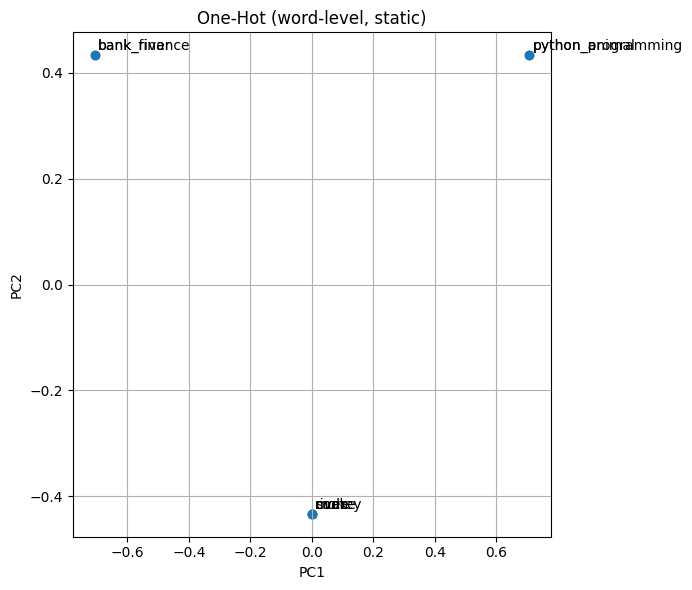

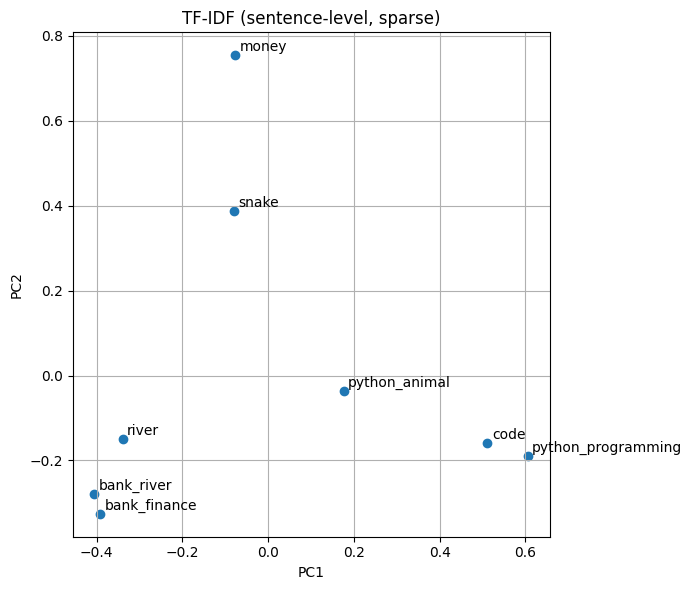

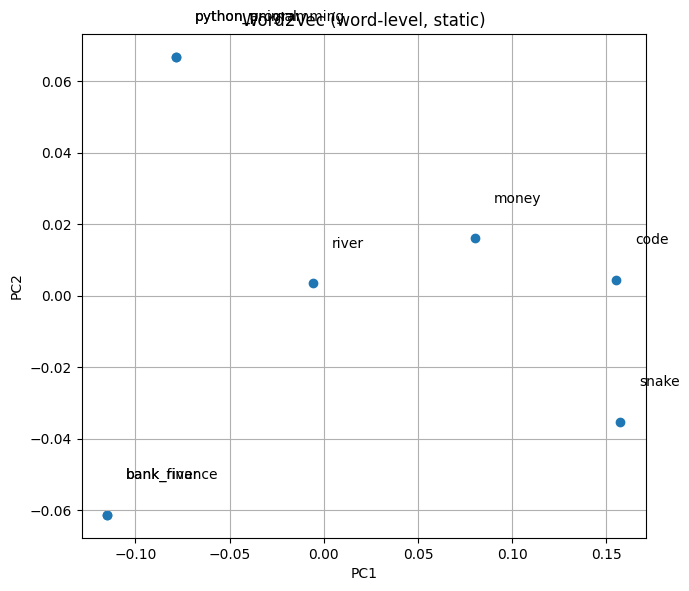

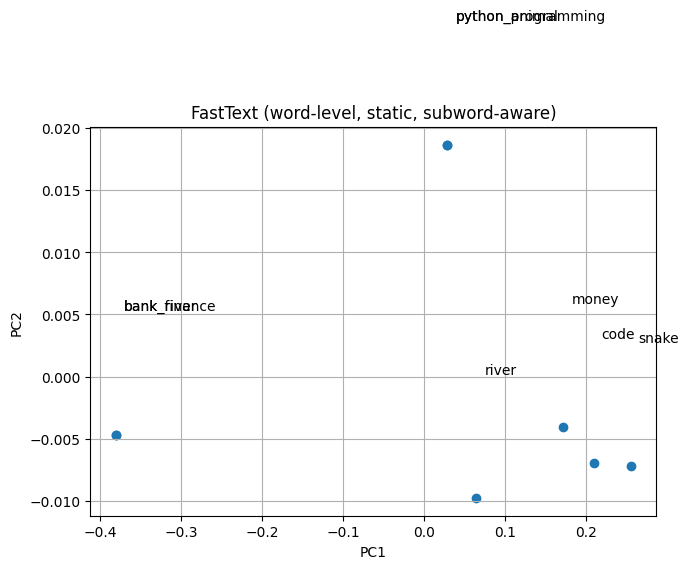

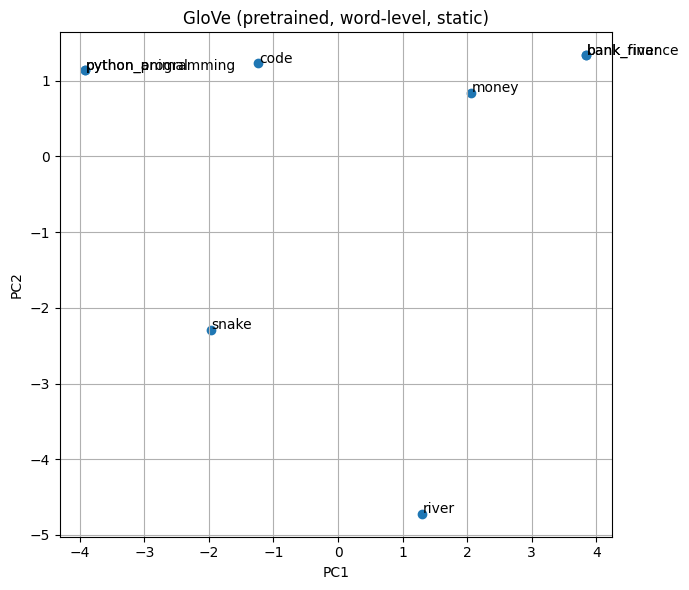

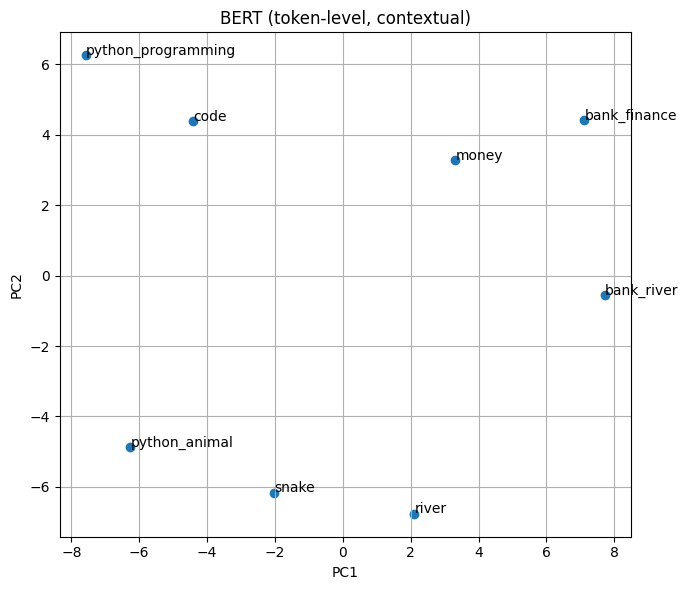

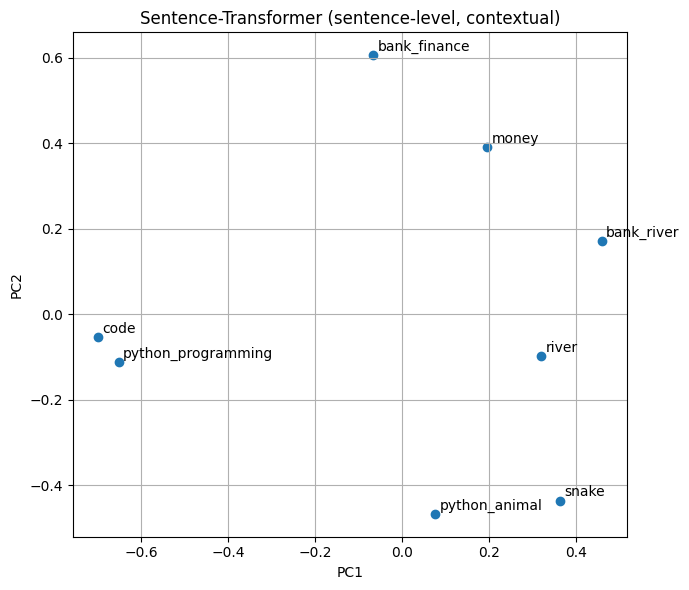

In [12]:
plot_2d(onehot_vectors, "One-Hot (word-level, static)", labels)
plot_2d(tfidf_vectors, "TF-IDF (sentence-level, sparse)", labels)
plot_2d(w2v_vectors, "Word2Vec (word-level, static)", labels)
plot_2d(ft_vectors, "FastText (word-level, static, subword-aware)", labels)
plot_2d(glove_vectors, "GloVe (pretrained, word-level, static)", labels)
plot_2d(bert_vectors, "BERT (token-level, contextual)", labels)
plot_2d(st_vectors, "Sentence-Transformer (sentence-level, contextual)", labels)


## 13) How to interpret the plots (quick guide)

- **One-hot**: no semantic structure (all words equally unrelated)
- **TF-IDF**: relatedness depends on shared terms, not meaning
- **Word2Vec/GloVe/FastText**: semantic clusters form, but "bank" is still one vector
- **BERT**: "bank_finance" and "bank_river" should separate due to context
- **Sentence-Transformers**: strongest sentence-level semantic clustering in many practical tasks


## Combined Embedding Visualization (All Methods + Legend)

This section plots all embedding spaces in a single figure for easy comparison.
Each subplot is a 2D PCA projection for one embedding type.

To make the legend meaningful, points are color-coded into semantic categories:
- Finance (bank_finance, money)
- Nature (bank_river, river, snake, python_animal)
- Tech (python_programming, code)

This helps visually evaluate whether each embedding method clusters related concepts.


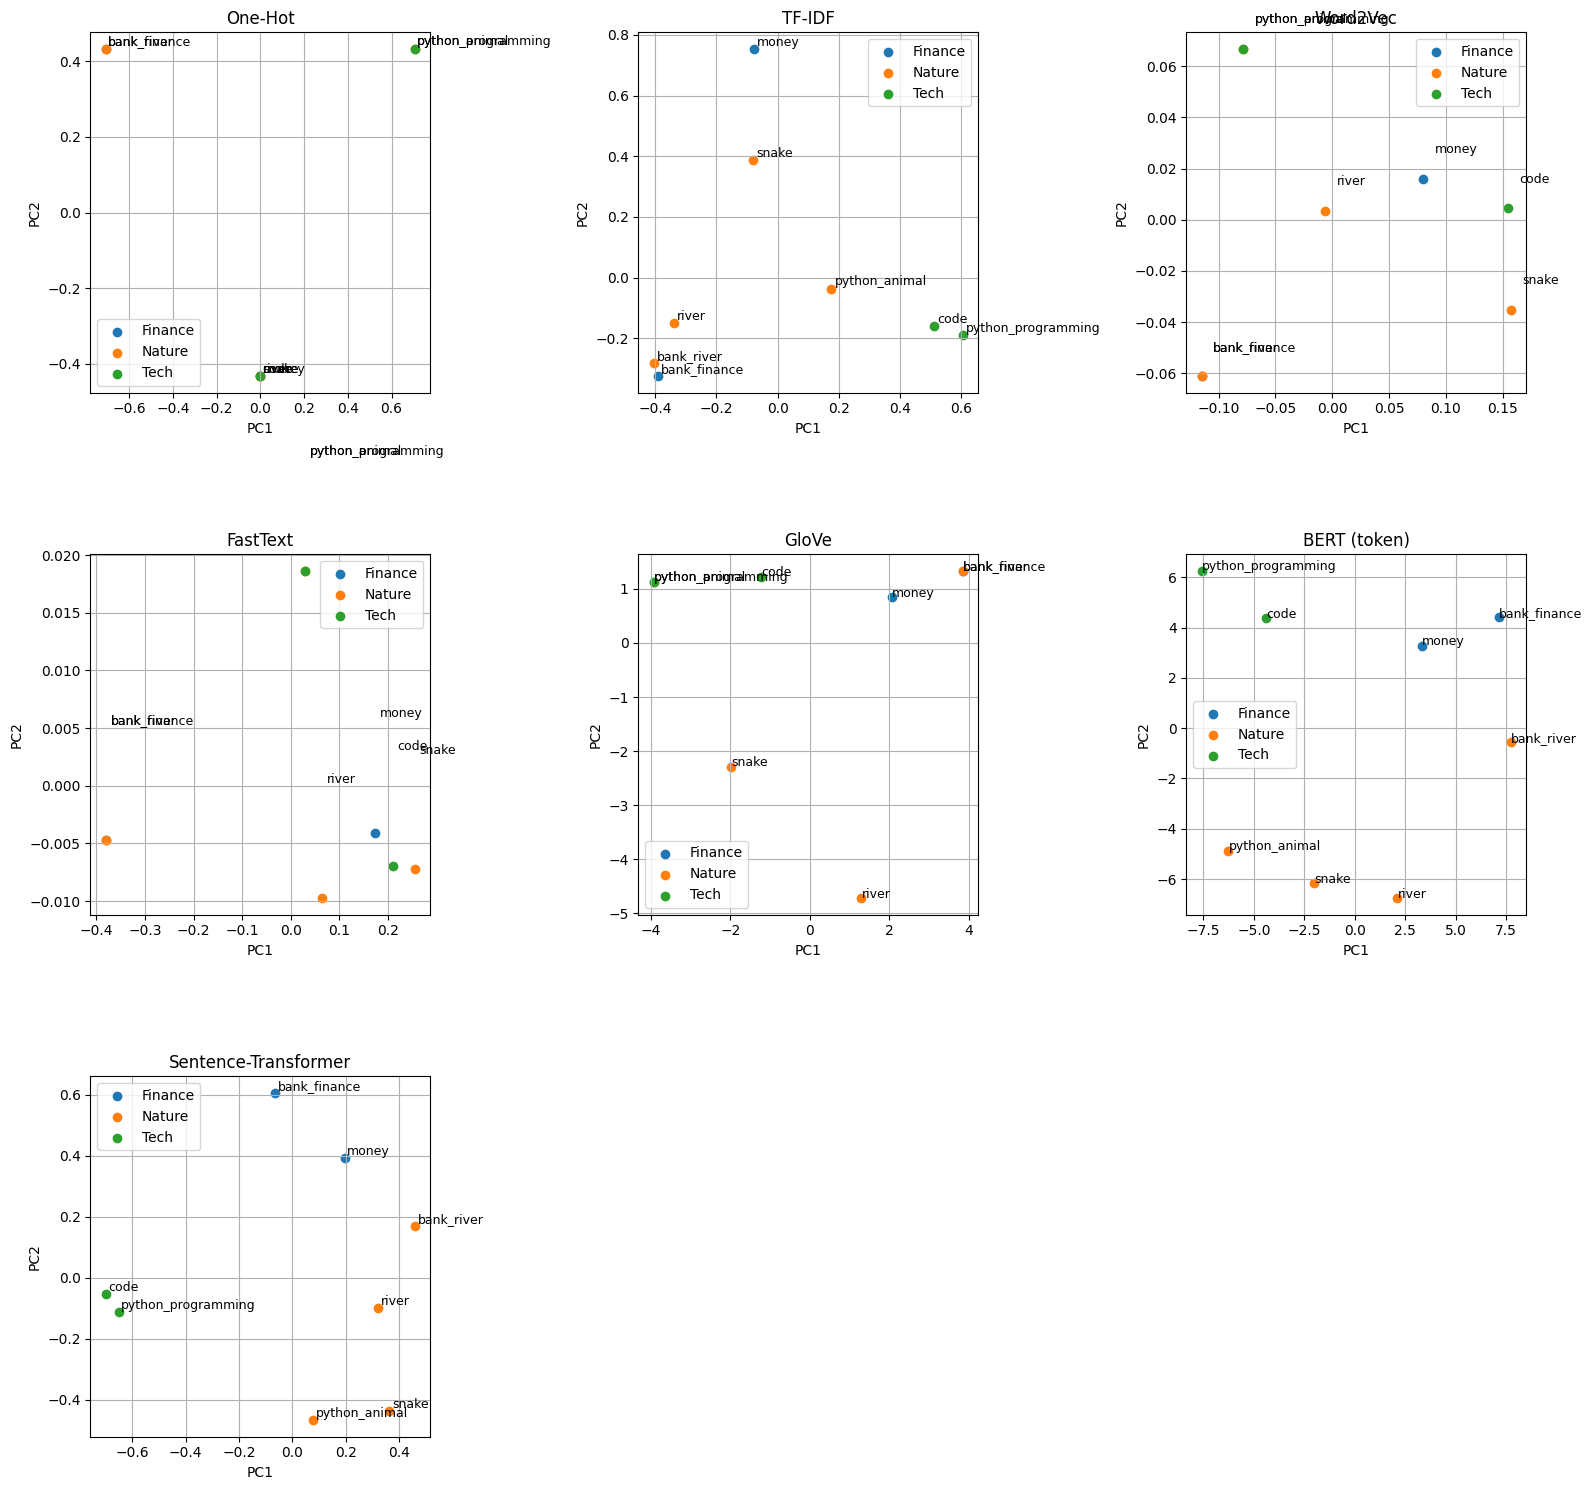

In [14]:
from sklearn.decomposition import PCA

# ----------------------------
# 1) Category mapping for legend
# ----------------------------
category_map = {
    "bank_finance": "Finance",
    "money": "Finance",
    "bank_river": "Nature",
    "river": "Nature",
    "snake": "Nature",
    "python_animal": "Nature",
    "python_programming": "Tech",
    "code": "Tech"
}

categories = [category_map[l] for l in labels]
unique_categories = sorted(list(set(categories)))

# Assign each category an index (matplotlib will choose colors automatically)
cat_to_idx = {c: i for i, c in enumerate(unique_categories)}
cat_idx = np.array([cat_to_idx[c] for c in categories])

# ----------------------------
# 2) Embedding dictionary (name -> vectors)
# ----------------------------
embeddings_dict = {
    "One-Hot": onehot_vectors,
    "TF-IDF": tfidf_vectors,
    "Word2Vec": w2v_vectors,
    "FastText": ft_vectors,
    "GloVe": glove_vectors,
    "BERT (token)": bert_vectors,
    "Sentence-Transformer": st_vectors
}

# ----------------------------
# 3) Plot in a grid (with legends)
# ----------------------------
n_plots = len(embeddings_dict)
ncols = 3
nrows = int(np.ceil(n_plots / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 5 * nrows))
axes = axes.flatten()

for ax_i, (name, vecs) in enumerate(embeddings_dict.items()):
    ax = axes[ax_i]

    # PCA -> 2D
    pca = PCA(n_components=2, random_state=42)
    pts = pca.fit_transform(vecs)

    # Scatter points by category (legend meaningful)
    for cat in unique_categories:
        mask = np.array(categories) == cat
        ax.scatter(pts[mask, 0], pts[mask, 1], label=cat)

    # Add text labels
    for i, lab in enumerate(labels):
        ax.text(pts[i, 0] + 0.01, pts[i, 1] + 0.01, lab, fontsize=9)

    ax.set_title(name)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.grid(True)
    ax.legend()

# Hide any unused subplot axes
for j in range(ax_i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()